In [1]:
! pip install -q kaggle
! mkdir /root/.kaggle
! cp kaggle.json /root/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [2]:
!kaggle datasets download -d mlg-ulb/creditcardfraud

 97% 64.0M/66.0M [00:02<00:00, 22.0MB/s]
100% 66.0M/66.0M [00:02<00:00, 29.8MB/s]


In [3]:
!unzip creditcardfraud.zip

Archive:  creditcardfraud.zip
  inflating: creditcard.csv          


In [112]:
!pip install -q scikit-plot

In [113]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import time

from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from collections import Counter

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report, plot_precision_recall_curve
from sklearn.metrics import roc_auc_score
import scikitplot as skplt
import warnings
warnings.filterwarnings("ignore")

In [5]:
df = pd.read_csv('creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Checking for Missing Values

In [6]:
df.isnull().sum().max()

0

In [7]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,1.768627e-15,9.170318e-16,-1.810658e-15,1.693438e-15,1.479045e-15,3.482336e-15,1.392007e-15,-7.528491e-16,4.328772e-16,9.049732e-16,5.085503e-16,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [8]:
print('Not Fraud:', round(df['Class'].value_counts()[0]))
print('Fraud:', round(df['Class'].value_counts()[1]))

Not Fraud: 284315
Fraud: 492


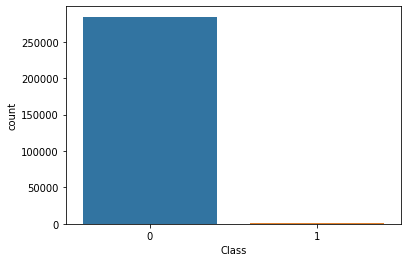

In [9]:
sns.countplot('Class', data=df)

From above plot, we can see Class Column is imbalanced

Scaling Data

In [10]:
from sklearn.preprocessing import RobustScaler

Robust Scaler is less prone to overfitting

In [11]:
rob_scaler = RobustScaler()

df['scaled_amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1))

df.drop(['Time','Amount'], axis=1, inplace=True)

In [12]:
scaled_amount = df['scaled_amount']

df.drop(['scaled_amount'], axis=1, inplace=True)
df.insert(0, 'scaled_amount', scaled_amount)
df.head()

,scaled_amount,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,1.783274,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.269825,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,4.983721,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,1.418291,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,0.670579,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


In [13]:
X = df.iloc[:,:-1]
y = df['Class']

**Technique 1:** Training without resampling dataset.

In [132]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Using Logistic Regression because Class column is binary

In [133]:
lr= LogisticRegression(C=1.0,penalty='l2',class_weight="balanced",n_jobs=-1)

In [134]:
lr.fit(X_train,y_train)

LogisticRegression(class_weight='balanced', n_jobs=-1)

In [135]:
labels = ['Not Fraud', 'Fraud']
prediction = lr.predict(X_test)

In [140]:
y_proba = lr.predict_proba(X_test)

In [136]:
print("Accuracy Score for Logistic Regression is {0:.2f} %".format(accuracy_score(y_test, prediction)*100))

Accuracy Score for Logistic Regression is 97.45 %


In [137]:
print(classification_report(y_test, prediction, target_names=labels))

              precision    recall  f1-score   support

   Not Fraud       1.00      0.97      0.99     56864
       Fraud       0.06      0.92      0.11        98

    accuracy                           0.97     56962
   macro avg       0.53      0.95      0.55     56962
weighted avg       1.00      0.97      0.99     56962



In [138]:
cf = confusion_matrix(y_test, prediction)

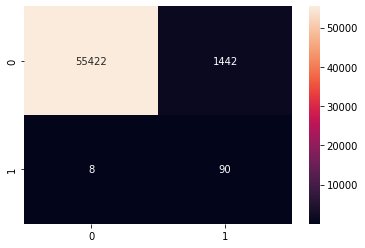

In [139]:
sns.heatmap(cf,annot=True,fmt='d')

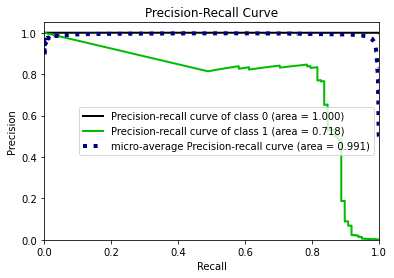

In [141]:
skplt.metrics.plot_precision_recall(y_test, y_proba)

Trying Random Forest Classifier

In [142]:
rfc = RandomForestClassifier(class_weight="balanced",n_jobs=-1) 
rfc.fit(X_train, y_train) 
y_pred = rfc.predict(X_test)

In [147]:
y_proba = rfc.predict_proba(X_test)

In [143]:
print("Accuracy Score for Random Forest is {0:.2f} %".format(accuracy_score(y_test, y_pred)*100))

Accuracy Score for Random Forest is 99.95 %


In [144]:
print(classification_report(y_test, y_pred, target_names=labels))

              precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00     56864
       Fraud       0.96      0.74      0.84        98

    accuracy                           1.00     56962
   macro avg       0.98      0.87      0.92     56962
weighted avg       1.00      1.00      1.00     56962



In [145]:
cf2 = confusion_matrix(y_test, y_pred)

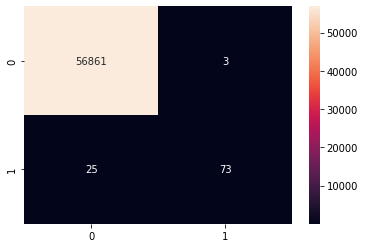

In [146]:
sns.heatmap(cf2,annot=True,fmt='d')

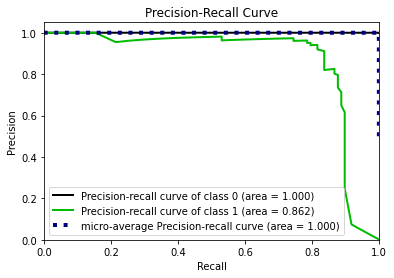

In [148]:
skplt.metrics.plot_precision_recall(y_test, y_proba)

It is clear from above confusion matrix that we are getting best accuracy using Random Forest Classifier

**Using Deep Learning**

In [89]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [90]:
y_train.value_counts()

0    227451
1       394
Name: Class, dtype: int64

In [91]:
n_inputs=len(X.columns)

In [92]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

checkpointer = ModelCheckpoint('fraud.hdf5', verbose=1, save_best_only=True)
earlystopper = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

In [93]:
# define model
model = Sequential()
# define first hidden layer and visible layer
model.add(Dense(50, input_dim=n_inputs, activation='relu', kernel_initializer='he_uniform'))
# define output layer
model.add(Dense(1, activation='sigmoid'))
# define loss and optimizer
model.compile(loss='binary_crossentropy', optimizer='adam', metrics='acc')

In [94]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))

In [95]:
class_weight_dict

{0: 0.5008661206149896, 1: 289.14340101522845}

In [96]:
model.fit(X_train,y_train,epochs=30,class_weight=class_weight_dict,validation_data = (X_test, y_test),callbacks=[checkpointer, earlystopper],workers=4)

Epoch 1/30
7120/7121 [============================>.] - ETA: 0s - loss: 0.2857 - acc: 0.9656
Epoch 00001: val_loss improved from inf to 0.13271, saving model to fraud.hdf5
7121/7121 [==============================] - 33s 5ms/step - loss: 0.2857 - acc: 0.9656 - val_loss: 0.1327 - val_acc: 0.9632
Epoch 2/30
7113/7121 [============================>.] - ETA: 0s - loss: 0.1467 - acc: 0.9696
Epoch 00002: val_loss improved from 0.13271 to 0.06684, saving model to fraud.hdf5
7121/7121 [==============================] - 30s 4ms/step - loss: 0.1466 - acc: 0.9696 - val_loss: 0.0668 - val_acc: 0.9875
Epoch 3/30
7111/7121 [============================>.] - ETA: 0s - loss: 0.1277 - acc: 0.9741
Epoch 00003: val_loss did not improve from 0.06684
7121/7121 [==============================] - 30s 4ms/step - loss: 0.1276 - acc: 0.9741 - val_loss: 0.0787 - val_acc: 0.9795
Epoch 4/30
7116/7121 [============================>.] - ETA: 0s - loss: 0.1175 - acc: 0.9725
Epoch 00004: val_loss did not improve from 

In [97]:
model.load_weights('fraud.hdf5')

In [119]:
y_proba=model.predict(X_test)

In [120]:
y_pred = (y_proba > 0.5)

In [101]:
print("Accuracy Score for Neural Network is {0:.2f} %".format(accuracy_score(y_test, y_pred)*100))

Accuracy Score for Neural Network is 98.58 %


In [102]:
print(classification_report(y_test, y_pred, target_names=labels))

              precision    recall  f1-score   support

   Not Fraud       1.00      0.99      0.99     56864
       Fraud       0.10      0.89      0.18        98

    accuracy                           0.99     56962
   macro avg       0.55      0.94      0.59     56962
weighted avg       1.00      0.99      0.99     56962



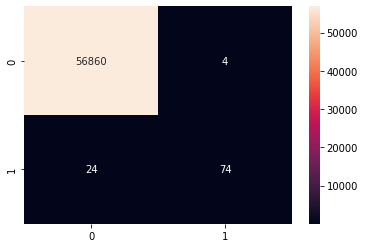

In [103]:
cf3 = confusion_matrix(y_test, y_pred)
sns.heatmap(cf2,annot=True,fmt='d')

In [130]:
new_proba = []
for prob in y_proba:
    if prob[0]>0.5:
        new_proba.append([1-prob[0],prob[0]])
    else:
        new_proba.append([prob[0],1-prob[0]])

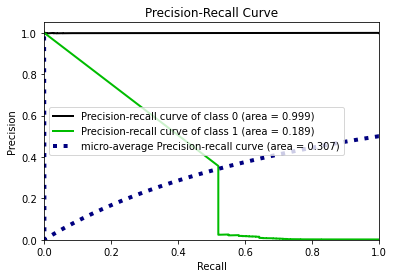

In [131]:
skplt.metrics.plot_precision_recall(y_test, new_proba)

**Technique 2:** Creating synthetic points for imbalanced class using SMOTE and then training on resampled dataset.

In [149]:
X_smote, y_smote = SMOTE(sampling_strategy='minority').fit_resample(X, y)

In [150]:
print("SMOTE data distribution: {}".format(Counter(y_smote)))

SMOTE data distribution: Counter({0: 284315, 1: 284315})


In [191]:
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size=0.2, random_state=42, stratify=y_smote)

In [192]:
estimators = {'lr':LogisticRegression(class_weight="balanced",n_jobs=-1),
              'rf' : RandomForestClassifier(class_weight="balanced",n_jobs=-1)}

In [193]:
acc = []
est = []
for estimator in estimators.values():
  estimator.fit(X_train, y_train) 
  y_pred = estimator.predict(X_test)
  est.append(estimator)
  acc.append(accuracy_score(y_test,y_pred))

In [194]:
acc

[0.9452895555985439, 0.999903276295658]

In [195]:
est[np.argmax(acc)]

RandomForestClassifier(class_weight='balanced', n_jobs=-1)

Random Forest is having more accuracy than Logistic Regression

In [196]:
y_pred = est[np.argmax(acc)].predict(X_test)
y_proba = est[np.argmax(acc)].predict_proba(X_test)

In [197]:
print("Accuracy Score for Random Forest is {0:.2f} %".format(accuracy_score(y_test, y_pred)*100))

Accuracy Score for Random Forest is 99.99 %


In [198]:
print(classification_report(y_test, y_pred, target_names=labels))

              precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00     56863
       Fraud       1.00      1.00      1.00     56863

    accuracy                           1.00    113726
   macro avg       1.00      1.00      1.00    113726
weighted avg       1.00      1.00      1.00    113726



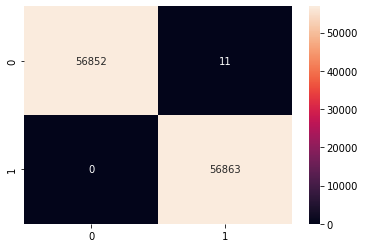

In [199]:
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,fmt='d')

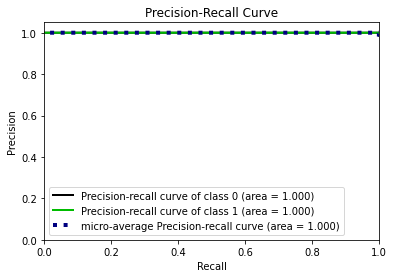

In [200]:
skplt.metrics.plot_precision_recall(y_test, y_proba)

In [201]:
checkpointer = ModelCheckpoint('fraud.hdf5', verbose=1, save_best_only=True)
earlystopper = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

In [202]:
# define model
model = Sequential()
# define first hidden layer and visible layer
model.add(Dense(50, input_dim=n_inputs, activation='relu', kernel_initializer='he_uniform'))
# define output layer
model.add(Dense(1, activation='sigmoid'))
# define loss and optimizer
model.compile(loss='binary_crossentropy', optimizer='adam', metrics='acc')

In [203]:
model.fit(X_train,y_train,epochs=30,validation_data = (X_test, y_test),callbacks=[checkpointer, earlystopper],workers=4)

Epoch 1/30
14214/14216 [============================>.] - ETA: 0s - loss: 0.0435 - acc: 0.9854
Epoch 00001: val_loss improved from inf to 0.01551, saving model to fraud.hdf5
14216/14216 [==============================] - 57s 4ms/step - loss: 0.0435 - acc: 0.9854 - val_loss: 0.0155 - val_acc: 0.9968
Epoch 2/30
14208/14216 [============================>.] - ETA: 0s - loss: 0.0110 - acc: 0.9975
Epoch 00002: val_loss improved from 0.01551 to 0.00954, saving model to fraud.hdf5
14216/14216 [==============================] - 60s 4ms/step - loss: 0.0110 - acc: 0.9975 - val_loss: 0.0095 - val_acc: 0.9978
Epoch 3/30
14209/14216 [============================>.] - ETA: 0s - loss: 0.0068 - acc: 0.9985
Epoch 00003: val_loss improved from 0.00954 to 0.00678, saving model to fraud.hdf5
14216/14216 [==============================] - 57s 4ms/step - loss: 0.0068 - acc: 0.9985 - val_loss: 0.0068 - val_acc: 0.9990
Epoch 4/30
14208/14216 [============================>.] - ETA: 0s - loss: 0.0053 - acc: 0.99

In [204]:
model.load_weights('fraud.hdf5')

In [205]:
y_proba = model.predict(X_test)

In [206]:
y_pred = (y_proba>0.5)

In [207]:
print("Accuracy Score for Neural Network is {0:.2f} %".format(accuracy_score(y_test, y_pred)*100))

Accuracy Score for Neural Network is 99.96 %


In [208]:
print(classification_report(y_test, y_pred, target_names=labels))

              precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00     56863
       Fraud       1.00      1.00      1.00     56863

    accuracy                           1.00    113726
   macro avg       1.00      1.00      1.00    113726
weighted avg       1.00      1.00      1.00    113726



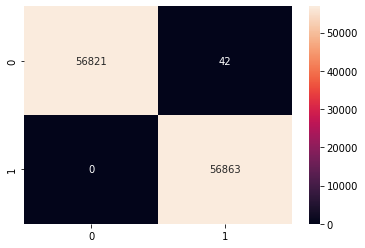

In [209]:
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,fmt='d')

In [210]:
new_proba = []
for prob in y_proba:
    if prob[0]>0.5:
        new_proba.append([1-prob[0],prob[0]])
    else:
        new_proba.append([prob[0],1-prob[0]])

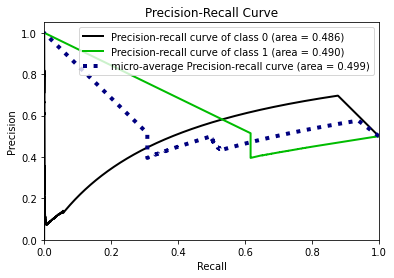

In [211]:
skplt.metrics.plot_precision_recall(y_test, np.array(new_proba))

# VERDICT:

**Random Forest outperformed both Logistic Regression and Neural Networks for this dataset.**